# Problem 6, MCMC Sampling

## Problem a)

In [132]:
import numpy as np
np.random.seed(0)

In [24]:
def gen_sample():
    r = np.random.rand(1)
    if r > 0.5:
        return np.random.normal(5, 1)
    else:
        return np.random.normal(-5, 1)

def gen_samples(n):
    samples = np.array([gen_sample() for i in range(n)])
    return samples

In [27]:
num_x_samples = 100
x_samples = gen_samples(num_x_samples)

## Problem b)

In [34]:
def cal_acceptance_rate(x_samples, mu1, mu2, mu1_h, mu2_h, sigma):
    alpha = cal_log_posterior(x_samples, mu1_h, mu2_h) - cal_log_posterior(x_samples, mu1, mu2)
    alpha = np.exp(alpha)
    
    # We do not need to calculate the transition probability, 
    # since it is 1 always in this case.
    transition_prob = 1
    alpha = alpha * 1
    
    return alpha

def cal_log_posterior(x_samples, mu1, mu2):
    # log p(mu1, mu2 | x)
    log_prob_mus = -1 * (mu1 ** 2 + mu2 ** 2) / 200
    
    # p(x | mu1, mu2)
    prob_x_1 = 0.5 * np.exp(-0.5 * (x_samples - mu1) ** 2)
    prob_x_2 = 0.5 * np.exp(-0.5 * (x_samples - mu2) ** 2)
    prob_x = prob_x_1 + prob_x_2
    
    return np.sum(np.log(prob_x)) + log_prob_mus

def metropolis_hastings_sampling(x_samples, num_samples, sigma):
    # Initialize mu1 and mu2 be 0 and 0
    mu1, mu2 = 0, 0
    mu1s, mu2s = np.zeros(num_samples), np.zeros(num_samples)
    accept_count = 0
    
    # Run Metropolis Hastings Sampling
    for n in range(num_samples):
        mu1_h = np.random.normal(mu1, sigma)
        mu2_h = np.random.normal(mu2, sigma)
        alpha = max(0, min(1, cal_acceptance_rate(x_samples, mu1, mu2, mu1_h, mu2_h, sigma)))
        if np.random.rand(1) < alpha:
            mu1 = mu1_h
            mu2 = mu2_h
            accept_count += 1
        mu1s[n] = mu1
        mu2s[n] = mu2
    
    acceptance_rate = accept_count / num_samples
    return mu1s, mu2s, acceptance_rate

sigma = 0.5


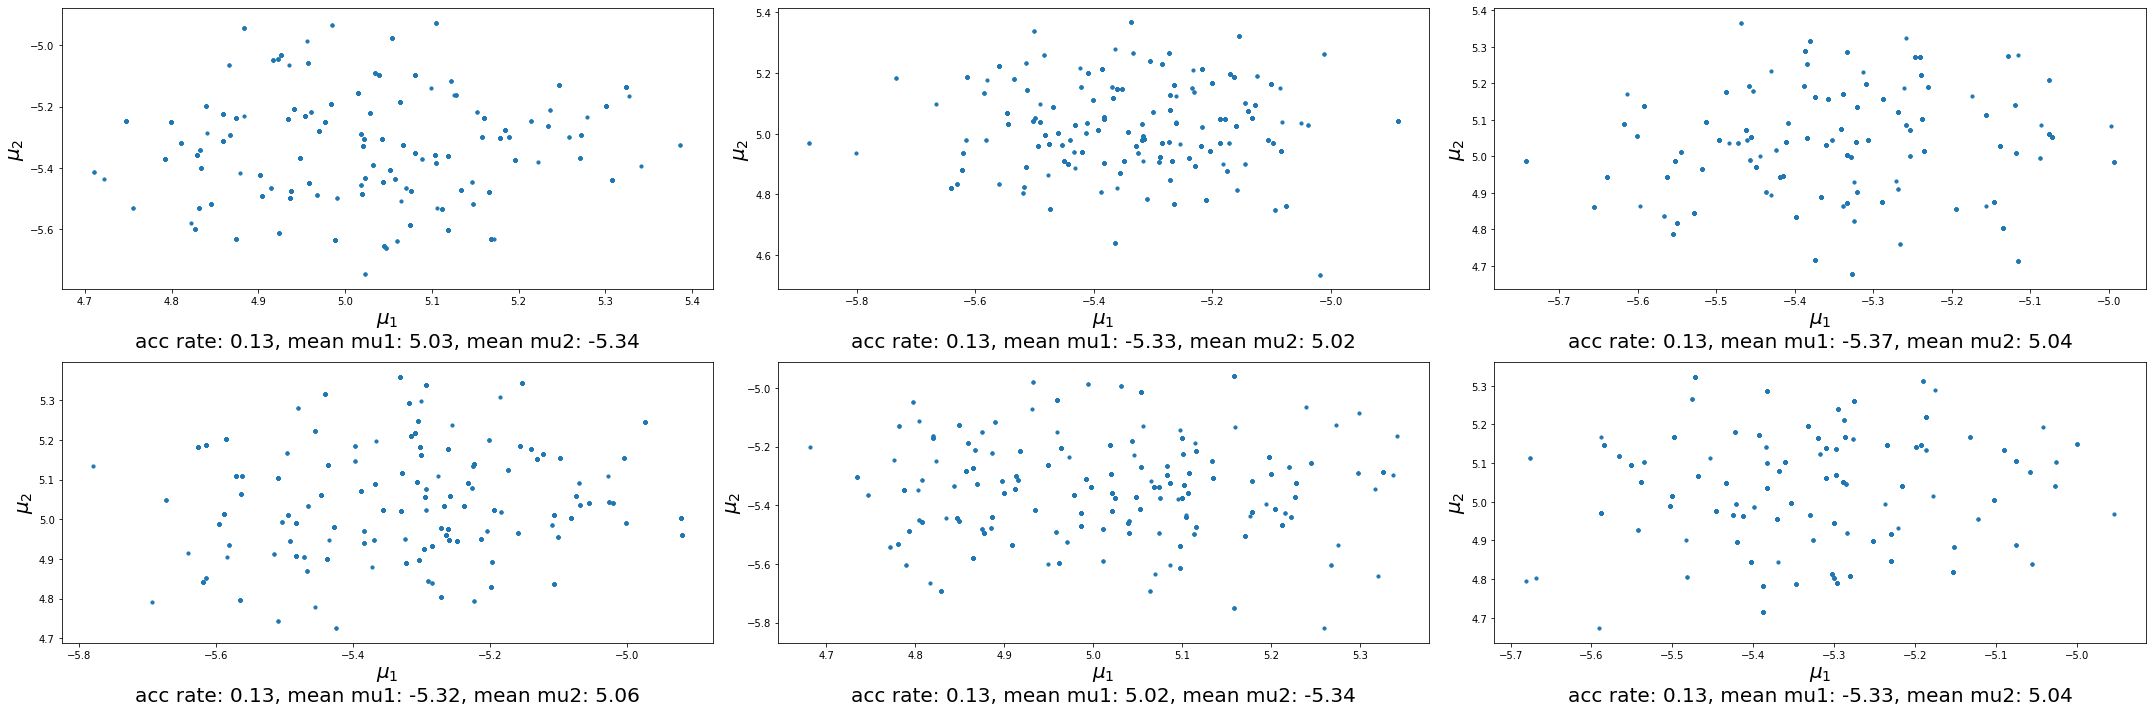

sigma = 5


/Users/haekyu/anaconda3/envs/massif/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


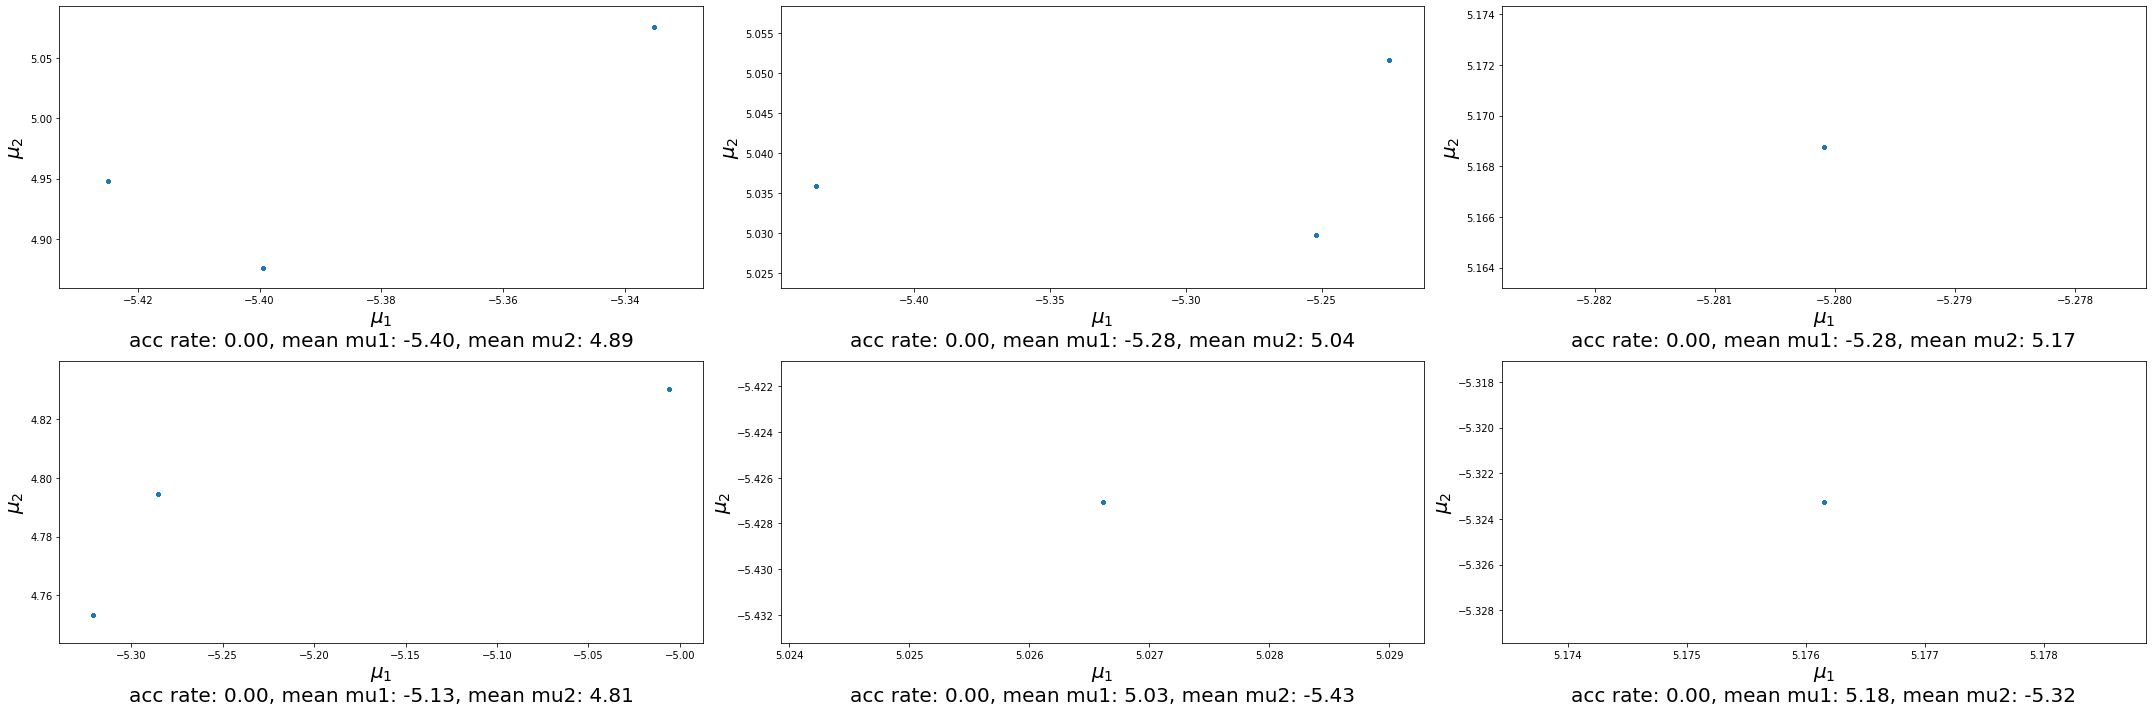

In [74]:
import matplotlib.pyplot as plt

num_samples = 11000
mean_mu1s = {}
mean_mu2s = {}
acc_rates = {}

for sigma in [0.5, 5]:
    print('sigma = {}'.format(sigma))
    
    mean_mu1s[sigma] = []
    mean_mu2s[sigma] = []
    acc_rates[sigma] = []
    
    plt.figure(figsize=(30, 10))
    for i in range(6):
        # Run Metropolis Hastings Sampling
        mu1s, mu2s, acceptance_rate = metropolis_hastings_sampling(
                                        x_samples, 
                                        num_samples, 
                                        sigma
                                      )
        # Discard the first 10000 samples
        mu1s = mu1s[10000:]
        mu2s = mu2s[10000:]

        # Plot the next 1000 samples of mu1 and mu2
        plt.subplot(231 + i)
        plt.scatter(mu1s, mu2s, s=10)
        plt.xlabel(r'$\mu_1$' + '\nacc rate: %.2lf, mean mu1: %.2lf, mean mu2: %.2lf' % (acceptance_rate, np.mean(mu1s), np.mean(mu2s)), fontsize=20)
        plt.ylabel(r'$\mu_2$', fontsize=20)
        plt.tight_layout()
        
        # Record the data
        mean_mu1s[sigma].append(np.mean(mu1s))
        mean_mu2s[sigma].append(np.mean(mu2s))
        acc_rates[sigma].append(acceptance_rate)

    plt.show()

In [77]:
import pandas as pd

sigma = 0.5
df_1 = pd.DataFrame()
df_1['mean_mu1'] = mean_mu1s[sigma]
df_1['mean_mu2'] = mean_mu2s[sigma]
df_1['acceptance rate'] = acc_rates[sigma]

df_1

,mean_mu1,mean_mu2,acceptance rate
0,5.025064,-5.340499,0.131000
1,-5.332442,5.021185,0.131091
2,-5.365892,5.035718,0.130727
3,-5.316841,5.056698,0.127909
4,5.019107,-5.335424,0.134545
5,-5.333710,5.039708,0.127909


In [79]:
sigma = 5
df_2 = pd.DataFrame()
df_2['mean_mu1'] = mean_mu1s[sigma]
df_2['mean_mu2'] = mean_mu2s[sigma]
df_2['acceptance rate'] = acc_rates[sigma]

df_2

,mean_mu1,mean_mu2,acceptance rate
0,-5.401915,4.894947,0.002273
1,-5.277091,5.037582,0.001455
2,-5.280091,5.168751,0.002182
3,-5.128976,4.807459,0.003273
4,5.026610,-5.427057,0.001909
5,5.176153,-5.323255,0.002182


## Problem c)

In [156]:
def get_z_samples(x_samples, mu1, mu2):
    z = np.zeros(len(x_samples), dtype=np.int8)
    
    prob = np.exp(-0.5 * (x_samples - mu1) ** 2) / (np.exp(-0.5*(x_samples - mu2) ** 2) + np.exp(-0.5 * (x_samples - mu1) ** 2))
    us = np.random.rand(len(z))
    
    # Mark that it represents data from mu1
    z[us < prob] = 1
    
    # Mark that it represents data from mu2
    z[us >= prob] = 2
    
    return z
    
def gibbs_sampling(x_samples, num_samples):
    # Initialize Gibbs sampling
    mu1, mu2 = 0, 0
    mu1s, mu2s = np.zeros(num_samples), np.zeros(num_samples)
    
    # Run Gibbs Sampling
    for n in range(num_samples):
        z = get_z_samples(x_samples, mu1, mu2).copy()

        mu1 = np.sum(z == 1)
        mu2 = np.sum(z == 2)
        
        mu1_h = 100 * np.sum((z == 1) * x_samples) / (100 * mu1 + 1)
        mu2_h = 100 * np.sum((z == 1) * x_samples) / (100 * mu2 + 1)
        
        mu1 = np.random.normal(mu1_h, np.sqrt(200 / (100 * mu1 + 1)))
        mu2 = np.random.normal(mu2_h, np.sqrt(200 / (100 * mu2 + 1)))

        mu1s[n] = mu1
        mu2s[n] = mu2
        
    return mu1s, mu2s

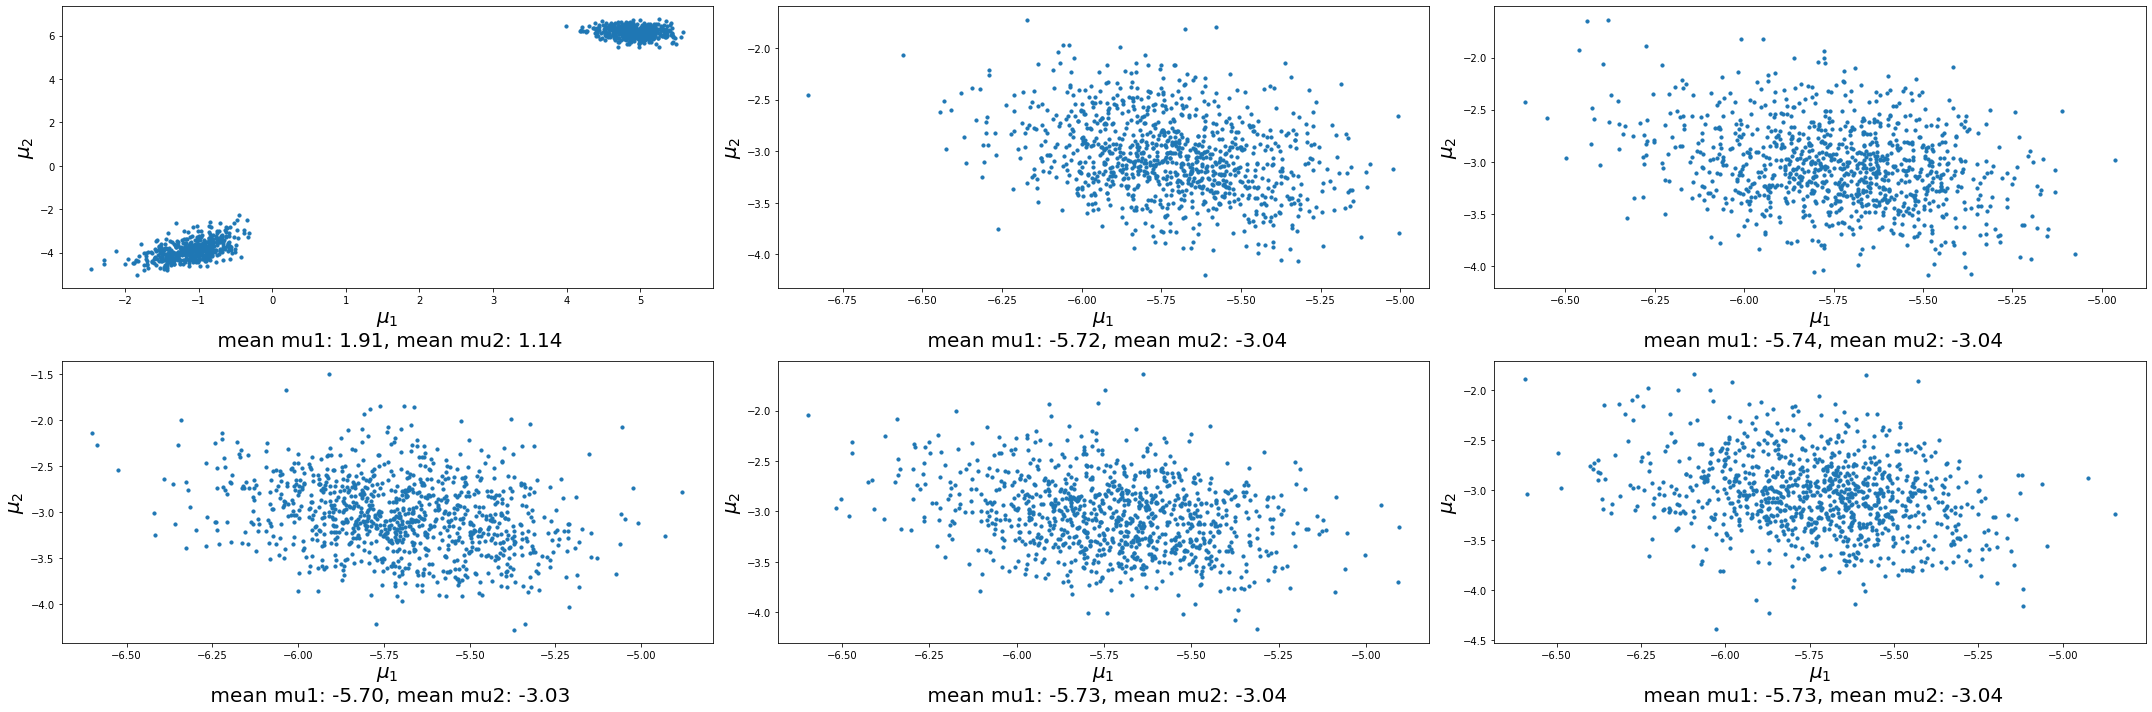

In [162]:
num_samples = 11000
gibbs_mean_mu1s = []
gibbs_mean_mu2s = []
    
plt.figure(figsize=(30, 10))
for i in range(6):
    # Run Gibbs Sampling
    gibbs_mu1s, gibbs_mu2s = gibbs_sampling(x_samples, num_samples)
    
    # Discard the first 10000 samples
    gibbs_mu1s = gibbs_mu1s[10000:]
    gibbs_mu2s = gibbs_mu2s[10000:]

    # Plot the next 1000 samples of mu1 and mu2
    plt.subplot(231 + i)
    plt.scatter(gibbs_mu1s, gibbs_mu2s, s=10)
    plt.xlabel(r'$\mu_1$' + '\n mean mu1: %.2lf, mean mu2: %.2lf' % (np.mean(gibbs_mu1s), np.mean(gibbs_mu2s)), fontsize=20)
    plt.ylabel(r'$\mu_2$', fontsize=20)
    plt.tight_layout()

    # Record the data
    gibbs_mean_mu1s.append(np.mean(gibbs_mu1s))
    gibbs_mean_mu2s.append(np.mean(gibbs_mu2s))

plt.show()

In [163]:
df = pd.DataFrame()
df['mean_mu1'] = gibbs_mean_mu1s
df['mean_mu2'] = gibbs_mean_mu2s

df

,mean_mu1,mean_mu2
0,1.912066,1.142613
1,-5.724099,-3.042464
2,-5.738514,-3.035543
3,-5.704386,-3.032615
4,-5.725242,-3.040966
5,-5.728205,-3.044541
